In [1]:
%config InlineBackend.figure_format = 'retina'

In [56]:
import numpy as np
import os
import glob
import warnings
from pathlib import Path
from matplotlib import pyplot as plt
from astropy.io import ascii, fits
from astropy.table import Table,Column
from datetime import datetime
from scipy.optimize import curve_fit
from scipy.ndimage import median_filter
from scipy.interpolate import UnivariateSpline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.feature import peak_local_max
from astropy.stats import sigma_clip, gaussian_fwhm_to_sigma
from numpy.polynomial.chebyshev import chebfit, chebval
from astropy.modeling.models import Gaussian1D, Chebyshev2D
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.visualization import ZScaleInterval
from matplotlib import gridspec, rcParams, rc
from IPython.display import Image
import preproc 

# plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14

WD = Path('./data/proj5')
RAWDIR = WD / 'raw' / 'P03hbahk0304145443GZ_data'
OUTDIR = WD / 'out'

if not OUTDIR.exists():
    OUTDIR.mkdir(parents=True)
    
warnings.filterwarnings('ignore', category=UserWarning, append=True)


In [31]:
def make_summary_table_focas(rawdir, suffix='.fits.gz'):
    """Make a summary table of the raw data in the directory. This function is
    specifically designed for the data taken with the FOCAS instrument.

    Args:
        rawdir (pathlib.Path): The directory containing the raw data.
        suffix (str, optional): The suffix of the raw data files. Defaults to
            '.fits.gz'.

    Returns:
        stab (astropy.table.Table): The summary table of the raw data in the directory.
        
    """
    # making a summary table
    summary = []
    for f in rawdir.glob('*'+suffix):
        hdr = fits.getheader(f)
        
        # getting the filter information from the header
        filt1 = hdr['FILTER01']
        filt2 = hdr['FILTER02']
        filt3 = hdr['FILTER03']
            
        X = hdr['AIRMASS'] # airmass
        disp = hdr['DISPERSR'] # disperser
        
        # appending the data to the summary list
        summary.append([f.name, hdr['DATE-OBS'], hdr['OBJECT'], hdr['RA'], hdr['DEC'],
                        hdr['DATA-TYP'], hdr['EXPTIME'], X, disp, hdr['SLT-WID'],
                        hdr['SLT-PA'], hdr['SLIT'], filt1, filt2, filt3, hdr['UT-STR'],
                        hdr['UT-END']])
        
    # creating the summary table
    stab = Table(rows=summary,
                 names=['filename', 'date-obs', 'object', 'ra', 'dec', 'type',
                        'exptime', 'airmass', 'disperser', 'slit-width', 'slit-pa',
                        'slit', 'filter1', 'filter2','filter3', 'ut-str', 'ut-end'],
                 dtype=['U50', 'U50', 'U50', 'U50', 'U50', 'U50', 'f8', 'f8', 'U50',
                        'f8', 'f8', 'U50', 'U50', 'U50', 'U50', 'U50', 'U50'])
    return stab

summary_table = make_summary_table_focas(RAWDIR)

In [32]:
summary_table.show_in_notebook(display_length=5)

idx,filename,date-obs,object,ra,dec,type,exptime,airmass,disperser,slit-width,slit-pa,slit,filter1,filter2,filter3,ut-str,ut-end
0,FCSA00141794.fits.gz,2013-06-07,DOMEFLAT,11:17:48.038,+19:54:08.26,DOMEFLAT,3.0,1.0,SCFCGRHD90,0.5,-90.3,SCFCSLLC08,NONE,SCFCFLSO58,NONE,04:37:11.906,04:37:15.139
1,FCSA00141920.fits.gz,2013-06-07,GRB 130606A,16:37:41.157,+29:47:45.71,OBJECT,1200.0,1.136,SCFCGRHD90,0.5,-90.3,SCFCSLLC08,NONE,SCFCFLSO58,NONE,07:59:00.676,08:19:01.117
2,FCSA00141930.fits.gz,2013-06-07,GRB 130606A,16:37:41.230,+29:47:45.13,OBJECT,1200.0,1.038,SCFCGRHD90,0.5,-90.3,SCFCSLLC08,NONE,SCFCFLSO58,NONE,09:03:28.980,09:23:29.405
3,FCSA00141848.fits.gz,2013-06-07,BIAS,11:39:50.841,+19:54:11.18,BIAS,0.0,1.0,SCFCGRMR01,0.5,-90.3,SCFCSLLC20,NONE,SCFCFLSO58,NONE,04:59:10.571,04:59:10.574
4,FCSA00141916.fits.gz,2013-06-07,GRB 130606A,16:37:41.020,+29:47:44.75,OBJECT,1200.0,1.254,SCFCGRHD90,0.5,-90.3,SCFCSLLC08,NONE,SCFCFLSO58,NONE,07:18:00.165,07:38:00.608
5,FCSA00141734.fits.gz,2013-06-06,BIAS,21:41:03.767,+17:46:28.41,BIAS,0.0,1.001,SCFCGRHD90,0.5,-0.3,SCFCSLLC20,NONE,SCFCFLSO58,NONE,14:53:03.807,14:53:03.810
6,FCSA00141566.fits.gz,2013-06-06,DOMEFLAT,11:23:03.374,+19:54:09.25,DOMEFLAT,1.1,1.0,SCFCGRHD90,0.5,-90.3,SCFCSLLC20,NONE,SCFCFLSO58,NONE,04:46:28.971,04:46:30.721
7,FCSA00141576.fits.gz,2013-06-06,DOMEFLAT,11:26:18.779,+19:54:09.76,DOMEFLAT,3.0,1.0,SCFCGRHD90,0.5,-90.3,SCFCSLLC08,NONE,SCFCFLSO58,NONE,04:49:43.639,04:49:46.993
8,FCSA00141822.fits.gz,2013-06-07,DOMEFLAT,11:26:05.681,+19:54:09.65,DOMEFLAT,1.1,1.0,SCFCGRHD90,0.5,-90.3,SCFCSLLC20,NONE,SCFCFLSO58,NONE,04:45:27.990,04:45:29.664
9,FCSA00141582.fits.gz,2013-06-06,COMPARISON,11:30:54.937,+19:54:10.37,COMPARISON,1.0,1.0,SCFCGRHD90,0.5,-90.3,SCFCSLLC20,NONE,SCFCFLSO58,NONE,04:54:18.901,04:54:20.208


In [77]:
biastab = summary_table[summary_table['type'] == 'BIAS']
flattab = summary_table[summary_table['type'] == 'DOMEFLAT']
arctab = summary_table[summary_table['type'] == 'COMPARISON']
scitab = summary_table[summary_table['object'] == 'GRB 130606A']
stdtab_f110 = summary_table[(summary_table['object'] == 'Feige110') &
                            (summary_table['type'] == 'OBJECT')]
stdtab_f34 = summary_table[(summary_table['object'] == 'Feige34') &
                            (summary_table['type'] == 'OBJECT')]

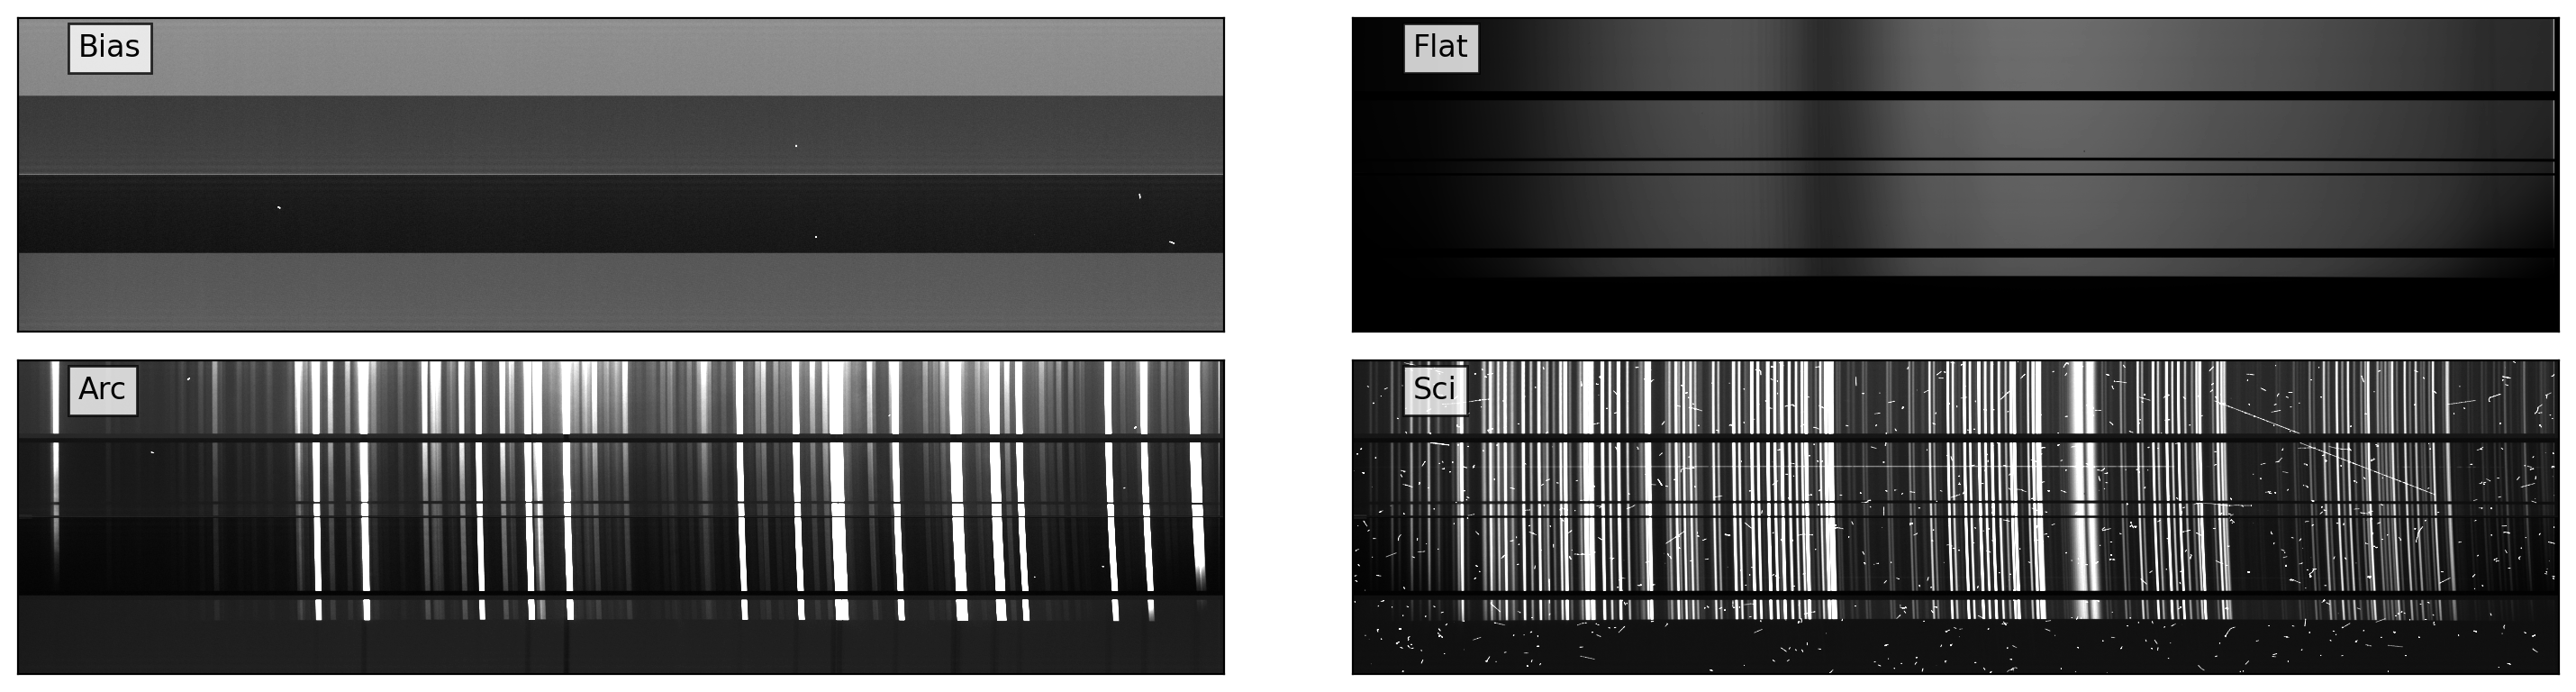

In [65]:
# for displaying in zscale
interval = ZScaleInterval()

# plotting the images
fig, axes = plt.subplots(2, 2, figsize=(15, 4))
titles = ['Bias', 'Flat', 'Arc', 'Sci']
bias = fits.getdata(RAWDIR / biastab['filename'][0])
flat = fits.getdata(RAWDIR / flattab['filename'][0])
arc = fits.getdata(RAWDIR / arctab['filename'][0])
sci = fits.getdata(RAWDIR / scitab['filename'][0])
for i, img in enumerate([bias, flat, arc, sci]):
    vmin, vmax = interval.get_limits(img)
    ax = axes[i // 2][i % 2]
    ax.imshow(img.T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
    ax.text(0.05, 0.95, titles[i], transform=ax.transAxes, ha='left', va='top',
            bbox=dict(facecolor='white', alpha=0.8))
    ax.tick_params(axis='both', length=0.0, labelleft=False, labelbottom=False)
plt.tight_layout()

del bias, flat, arc, sci

In [37]:
biaslist = [RAWDIR / f for f in biastab['filename']]
_ = preproc.combine_bias(biaslist, outdir=OUTDIR, outname='MBias.fits')
del _

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3105 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3105 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3105 of file cextern/wcslib/C/wcs.c:
Unmatched celestial 

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set DATE-END to '2013-06-07T04:59:10.645' from MJD-END'. [astropy.wcs.wcs]
  'degree' -> 'deg'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-06T14:53:03.880' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-06T04:56:58.652' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-07T04:59:35.780' from MJD-END'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3105 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3105 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3105 of file cextern/wcslib/C/wcs.c:
Unmatched celestial 

Set DATE-END to '2013-06-07T15:06:35.545' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-07T05:00:00.751' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-06T04:56:34.054' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-07T15:07:00.686' from MJD-END'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3105 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3105 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3105 of file cextern/wcslib/C/wcs.c:
Unmatched celestial 

Set DATE-END to '2013-06-07T15:07:53.456' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-06T04:56:09.042' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-06T14:53:29.035' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-07T15:06:10.558' from MJD-END'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3105 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3105 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3105 of file cextern/wcslib/C/wcs.c:
Unmatched celestial 

Set DATE-END to '2013-06-06T04:55:19.314' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-07T04:58:45.726' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-06T14:52:38.925' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-07T15:07:26.756' from MJD-END'. [astropy.wcs.wcs]


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3105 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3105 of file cextern/wcslib/C/wcs.c:
Unmatched celestial axes.
 [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: An exception happened while extracting WCS information from the Header.
InconsistentAxisTypesError: ERROR 4 in wcs_types() at line 3105 of file cextern/wcslib/C/wcs.c:
Unmatched celestial 

Set DATE-END to '2013-06-06T14:52:13.481' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-07T05:00:25.744' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-06T04:55:43.954' from MJD-END'. [astropy.wcs.wcs]
Set DATE-END to '2013-06-06T14:51:48.267' from MJD-END'. [astropy.wcs.wcs]


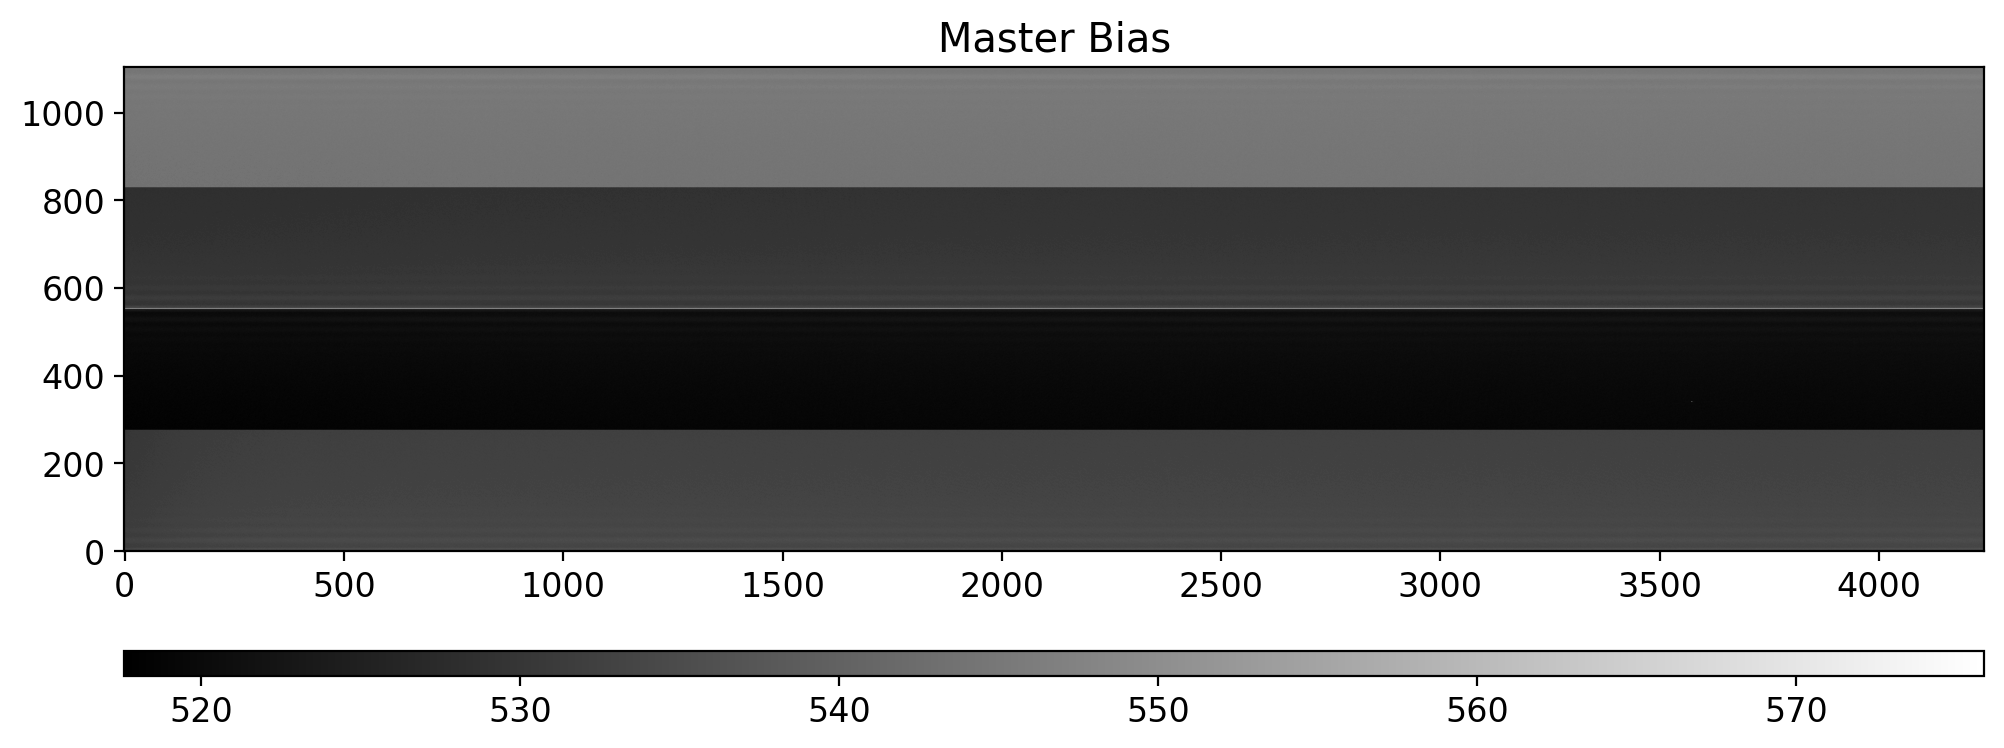

In [66]:
mbias = OUTDIR / 'MBias.fits'
mbias_img = fits.getdata(mbias)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
vmin, vmax = interval.get_limits(mbias_img)
im = ax.imshow(mbias_img.T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
ax.set_title('Master Bias')
divider = make_axes_locatable(ax)
cax = divider.append_axes('bottom', size='5%', pad=0.5)
plt.colorbar(im, cax=cax, orientation='horizontal')

## 1.4 Making Master Flat
Not like the photometric observation, spectroscopic flat image is typically taken with something like halogen lamp or tungsten lamp, which is inevitably not uniform especially for the dispersion direction. Therefore, we need to make a master flat image *flat*, which involves modeling the flat spectrum and dividing the flat image by the model. To obtain a good master flat, we need to:
1. **Examine the flat spectra**: do they show any variablity throughout the observation? can we combine them without any further consideration? do they have any features like wiggles or bumps? do they have any discontinuity?
2. **Model the flat spectra**: we can use a polynomial (or smoothing convolution) to model the flat spectrum. The degree of the polynomial (or size of the smoothing kernel) should be determined by the complexity of the flat spectrum.
3. **Normalize the flat spectra**: divide the flat image by the model to obtain a normalized flat image.

Combining can be done either before or after the modeling. If the flat spectra are stable, we can combine them first and then model the combined flat spectrum. If the flat spectra are not stable, we can model each flat spectrum and then combine the normalized flat images. If the flat spectra show significant variability, we can also consider not combining them at all.

Because of this complexity, making a master flat can be a time-consuming part of the data reduction process. Moreover, the quality of the master flat directly affects the quality of the reduced science images, which may introduce systematic errors if not done properly. Therefore, the spectroscopic flat fielding is often omitted in the data reduction process, when the flat fielding conversely introduces more errors than it corrects.

### 1.4-1 Checking for Flat Image Shift
The flat image may shift slightly depending on the telescope's pointing direction. Since different images might require different flats, it can be risky to median combine all the flat images taken overnight. We should perform a quick and rough check to see if there is a shift in the flat images.

To avoid bias might arise from this shift, it is recommended to take flat images at the same pointing direction as the science images. However, if the shift is small, we can still use the median combined flat image for calibration.

In this notebook, we will skip this process for simplicity, but you should always check for flat image shift in your own data. We will assume that the flat images are already aligned, and we will proceed to combine them.

In [58]:
flattab_exp3 = flattab[flattab['exptime'] == 3.0]
flattab_exp1 = flattab[flattab['exptime'] == 1.1]
flatlist_exp3 = [RAWDIR / f for f in flattab_exp3['filename']]
flatlist_exp1 = [RAWDIR / f for f in flattab_exp1['filename']]

mbias = OUTDIR / 'MBias.fits'
_ = preproc.make_master_flat(flatlist_exp3, outdir=OUTDIR, outname='MFlat03.0.fits', 
                             mbias=mbias, filter_key='FILTER02')
_ = preproc.make_master_flat(flatlist_exp1, outdir=OUTDIR, outname='MFlat01.1.fits',
                             mbias=mbias, filter_key='FILTER02')
del _


Flat frame 1
  DATE-OBS = 2013-06-07
  EXPTIME = 3.0
  FILTER02 = SCFCFLSO58

Flat frame 2
  DATE-OBS = 2013-06-06
  EXPTIME = 3.0
  FILTER02 = SCFCFLSO58

Flat frame 3
  DATE-OBS = 2013-06-06
  EXPTIME = 3.0
  FILTER02 = SCFCFLSO58

Flat frame 4
  DATE-OBS = 2013-06-07
  EXPTIME = 3.0
  FILTER02 = SCFCFLSO58

Flat frame 5
  DATE-OBS = 2013-06-06
  EXPTIME = 3.0
  FILTER02 = SCFCFLSO58

Flat frame 6
  DATE-OBS = 2013-06-07
  EXPTIME = 3.0
  FILTER02 = SCFCFLSO58

Flat frame 7
  DATE-OBS = 2013-06-06
  EXPTIME = 3.0
  FILTER02 = SCFCFLSO58

Flat frame 8
  DATE-OBS = 2013-06-07
  EXPTIME = 3.0
  FILTER02 = SCFCFLSO58

Flat frame 9
  DATE-OBS = 2013-06-06
  EXPTIME = 3.0
  FILTER02 = SCFCFLSO58

Flat frame 10
  DATE-OBS = 2013-06-07
  EXPTIME = 3.0
  FILTER02 = SCFCFLSO58

Combining flat frames with sigma clipping... 10 frames

Flat frame 1
  DATE-OBS = 2013-06-06
  EXPTIME = 1.1
  FILTER02 = SCFCFLSO58

Flat frame 2
  DATE-OBS = 2013-06-07
  EXPTIME = 1.1
  FILTER02 = SCFCFLSO58

Flat f

####  Comparing with the Standard Star Profile

Typical flat spectra shows many wiggles and bumps. Yet, we don't know if these features are originated from the grating, which in turn will affect our science frame equally. If they are not due to the grating, such as filters in front of the flat-field lamp, the extreme difference in color temperature between the lamps and the object of interest, or wavelength-dependent variations in the reflectivity of the paint used for the flat-field screen ([Massey & Hansen, 2010](https://arxiv.org/abs/1010.5270)), they are not going to present on the science frame. 

Let's see if a supposedly smooth source (in this case, a standard star) has same "wiggles" and "bumps" on its spectrum. If this is the case, we should model the flat lamp with "high order" and normalize the flat image with this model. If not, we should adopt "low-order" model or constant to normalize our flat field.

Text(0.5, 1.0, 'Master Flat (3.0s)')

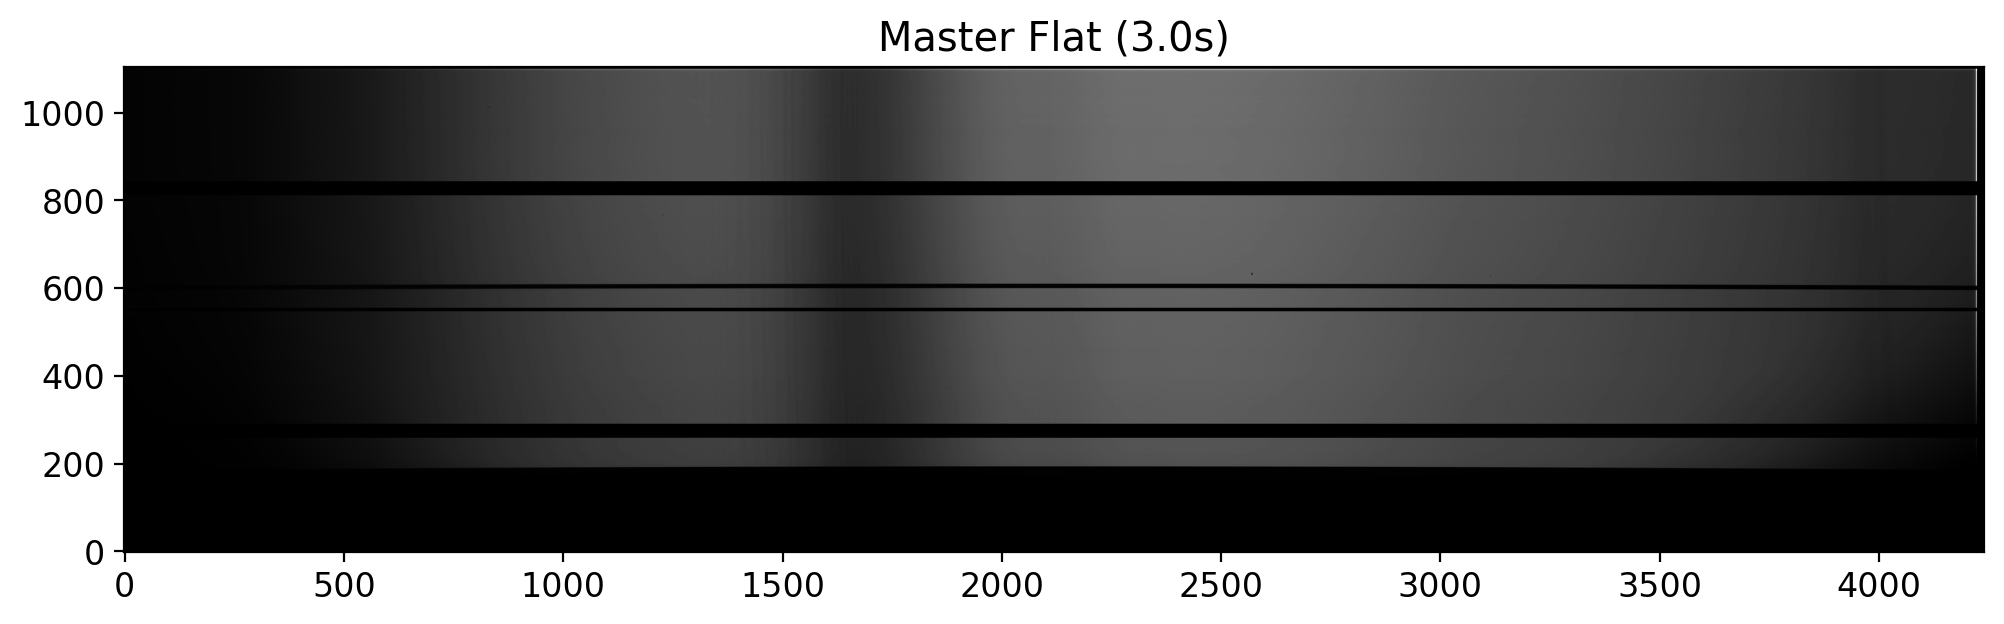

In [68]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
flat03 = fits.getdata(OUTDIR / 'MFlat03.0.fits')
vmin, vmax = interval.get_limits(flat03)
im = ax.imshow(flat03.T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
ax.set_title('Master Flat (3.0s)')

Text(0.5, 1.0, 'Feige34 (Standard Star)')

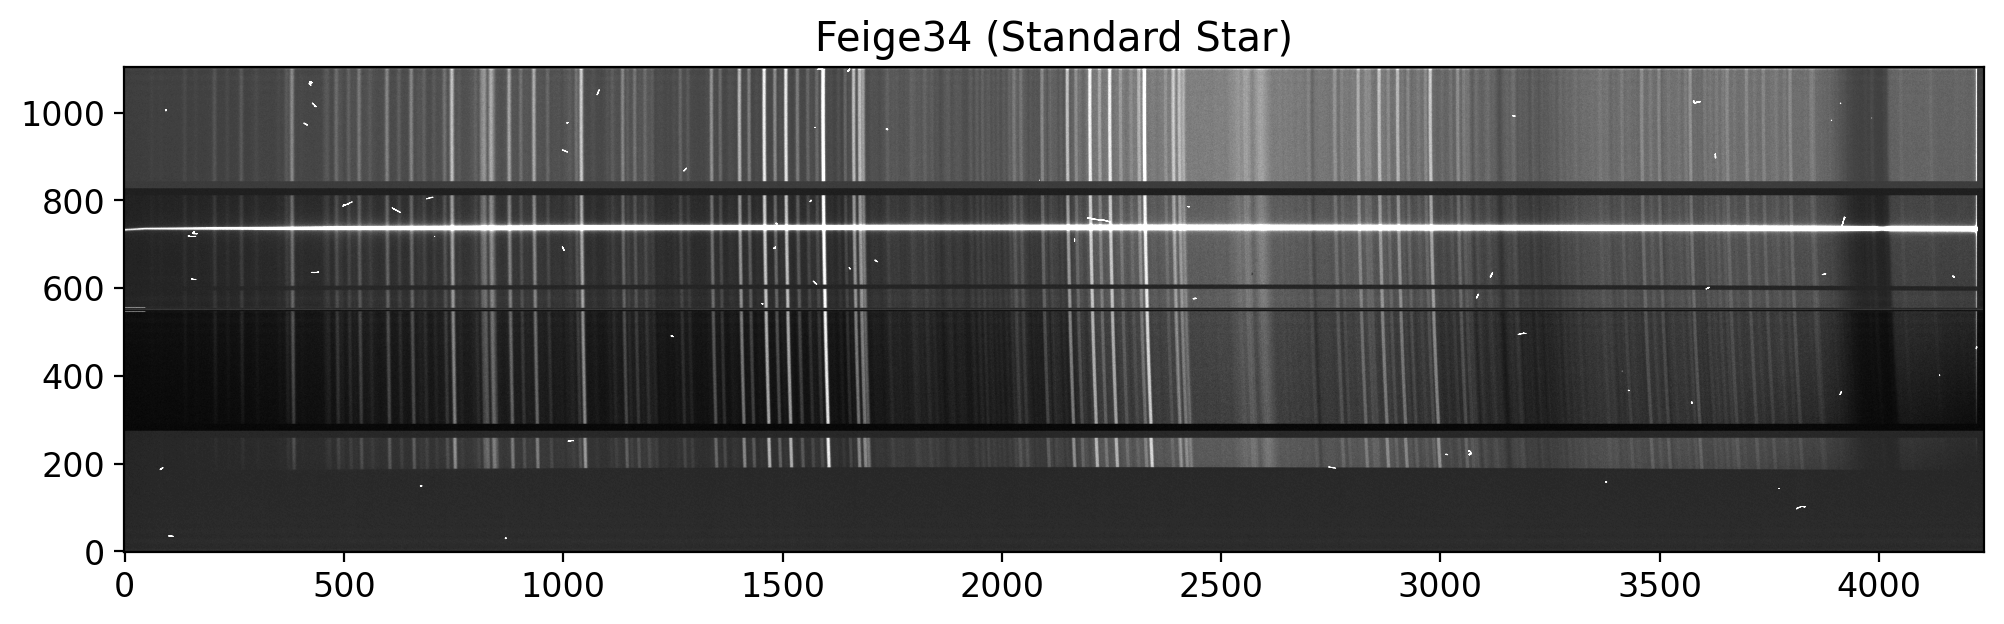

In [84]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
f34 = fits.getdata(RAWDIR / stdtab_f34['filename'][0])
vmin, vmax = interval.get_limits(f34)
im = ax.imshow(f34.T, cmap='gray', origin='lower', vmin=vmin, vmax=vmax)
ax.set_title('Feige34 (Standard Star)')

Text(0.05, 0.95, 'Feige34, Row 700, Raw')

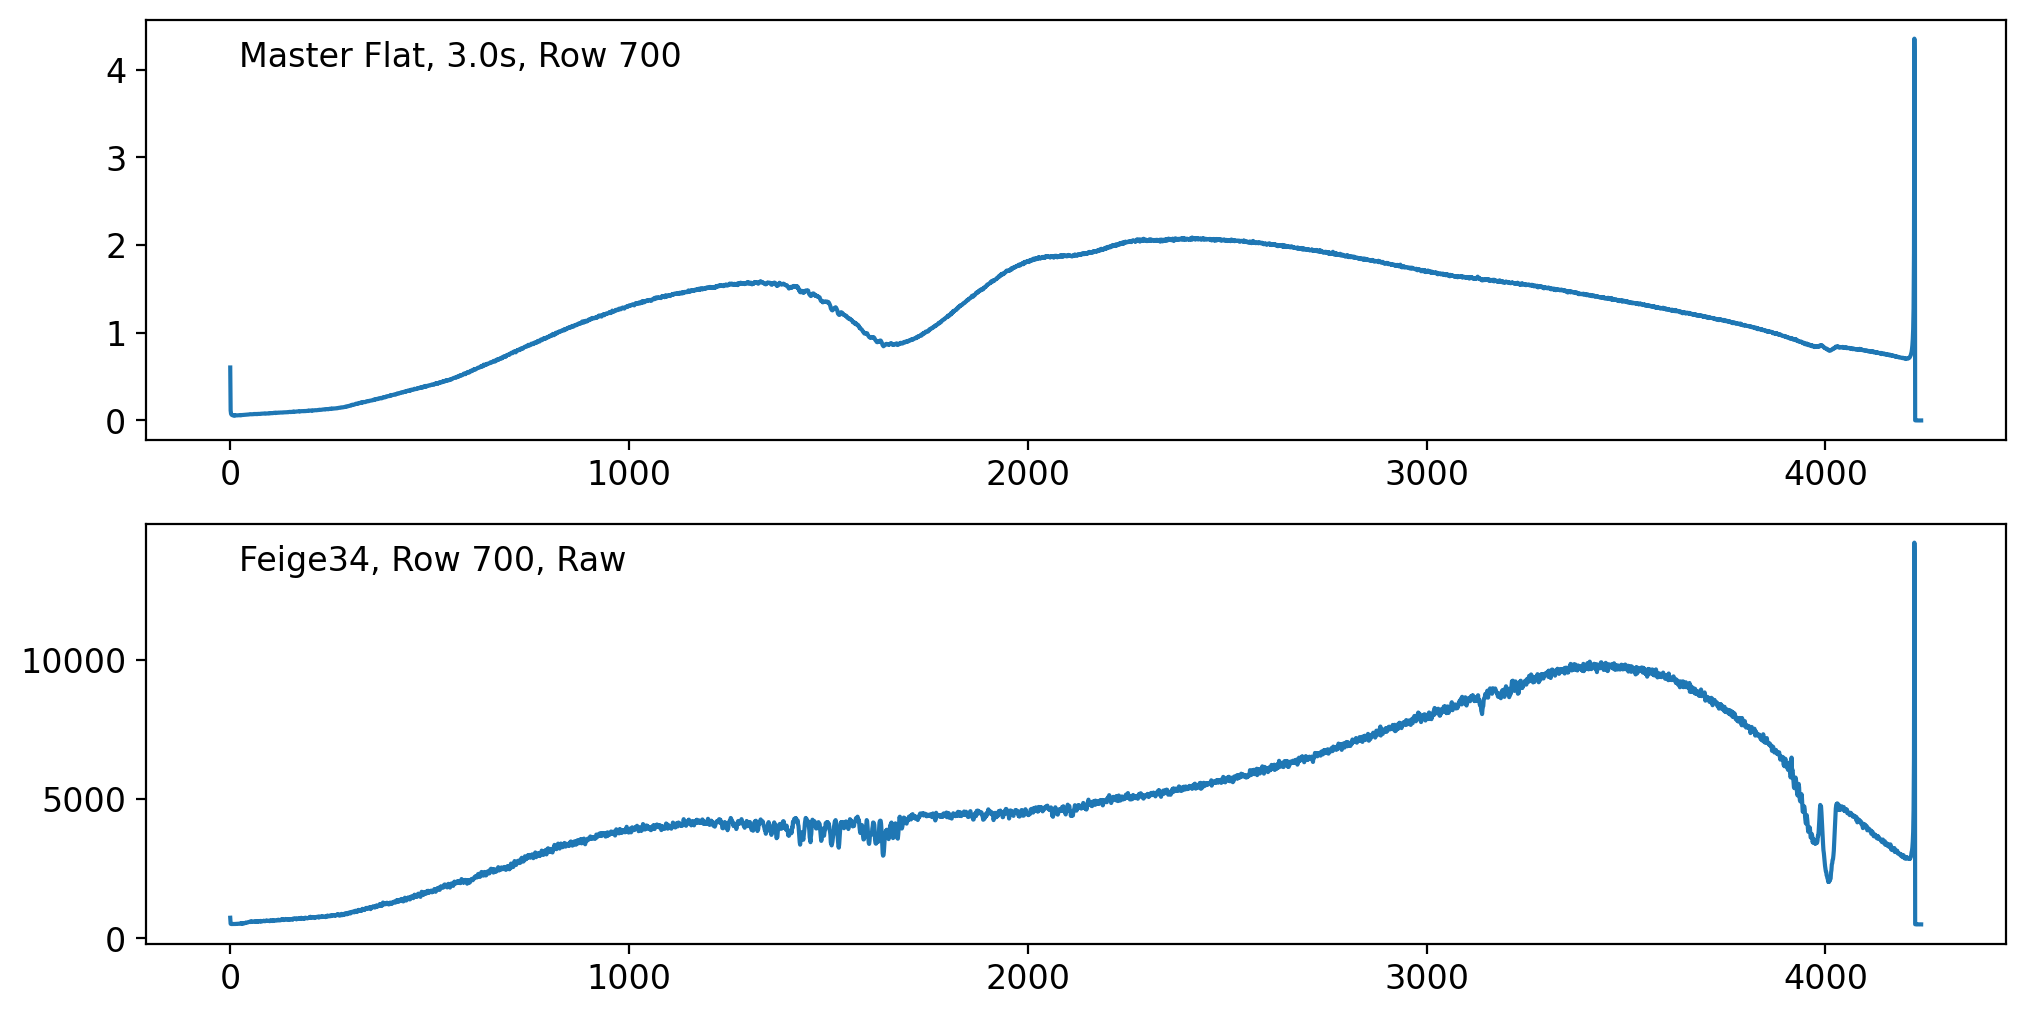

In [87]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(211)
ax.plot(flat03[:, 700])
ax.text(0.05, 0.95, 'Master Flat, 3.0s, Row 700', transform=ax.transAxes,
        ha='left', va='top')
ax = fig.add_subplot(212)
ax.plot(f34[:, 737])
ax.text(0.05, 0.95, 'Feige34, Row 700, Raw', transform=ax.transAxes,
        ha='left', va='top')

Although we can see some tiny wiggles in the flat spectrum, this is not significant enough to adopt higher-order polynomials to model the flat spectrum, as opposed to the case if we have significant fringe patterns. If you closely examine the flat spectrum, you will see that the wiggles are not random, but rather located at the atmospheric absorption lines. This is because the flat image is taken with a lamp, and the lamp light is absorbed by the atmosphere at these absorption lines. Since the absorption lines are not random, we can safely ignore them when modeling the flat spectrum.

In [76]:
stdtab_f34

filename,date-obs,object,ra,dec,type,exptime,airmass,disperser,slit-width,slit-pa,slit,filter1,filter2,filter3,ut-str,ut-end
str50,str50,str50,str50,str50,str50,float64,float64,str50,float64,float64,str50,str50,str50,str50,str50,str50
FCSA00141882.fits.gz,2013-06-07,Feige34,10:39:30.966,+43:06:49.52,COMPARISON,1.0,1.192,SCFCGRHD90,0.5,-240.3,SCFCSLLC08,NONE,SCFCFLSO58,NONE,05:51:10.923,05:51:12.178
FCSA00141880.fits.gz,2013-06-07,Feige34,10:39:30.972,+43:06:49.26,OBJECT,60.0,1.188,SCFCGRHD90,0.5,-240.3,SCFCSLLC08,NONE,SCFCFLSO58,NONE,05:49:08.496,05:50:08.794
FCSA00141894.fits.gz,2013-06-07,Feige34,10:39:30.923,+43:06:49.54,OBJECT,60.0,1.207,SCFCGRHD90,0.5,-240.3,SCFCSLLC20,NONE,SCFCFLSO58,NONE,05:58:05.720,05:59:05.978
FCSA00141878.fits.gz,2013-06-07,Feige34,10:39:30.978,+43:06:49.28,OBJECT,60.0,1.185,SCFCGRHD90,0.5,-240.3,SCFCSLLC08,NONE,SCFCFLSO58,NONE,05:47:32.380,05:48:32.720
